TASK 1

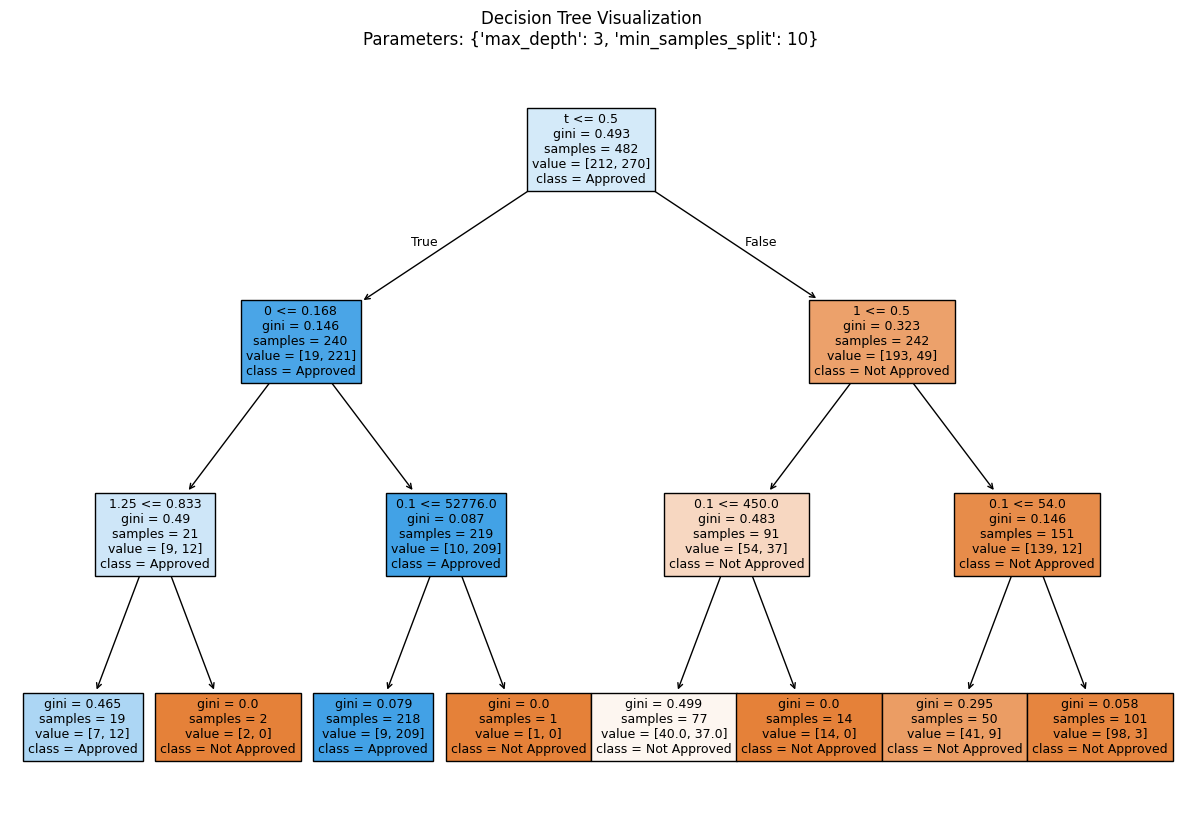

Test Accuracy: 0.84


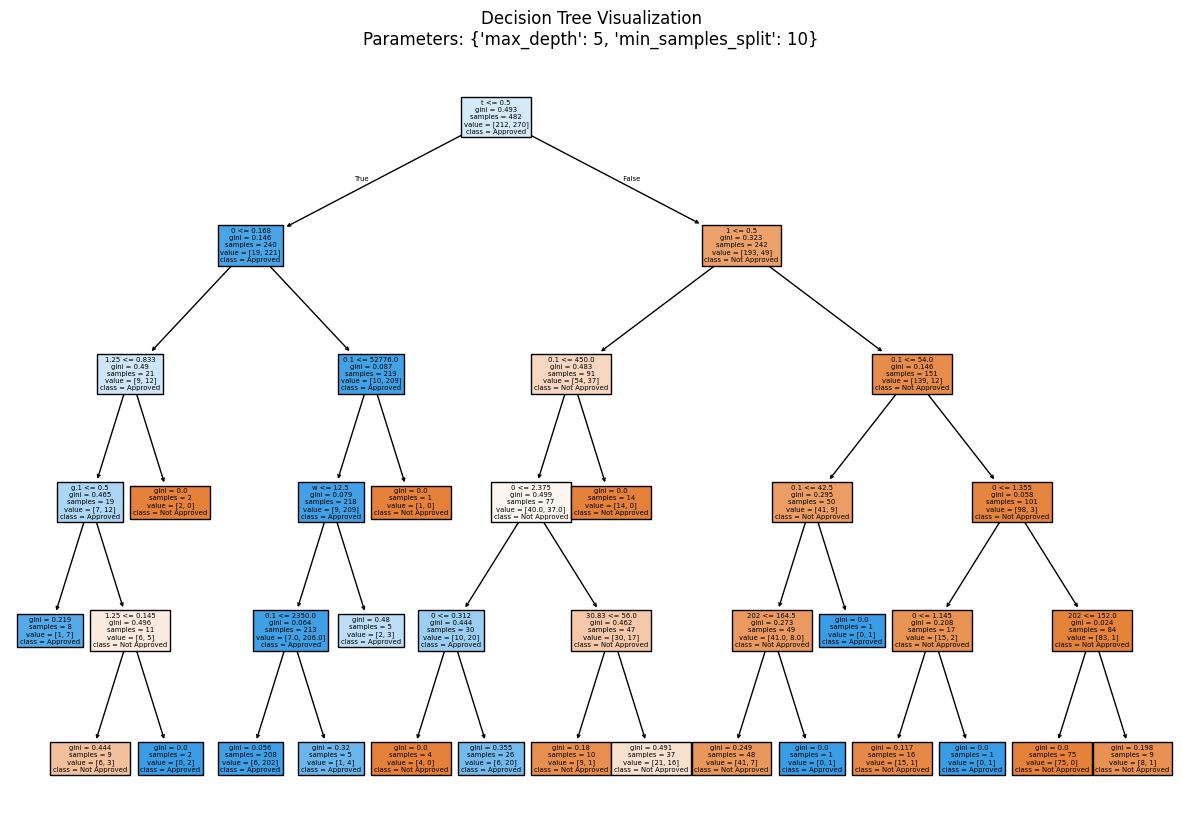

Test Accuracy: 0.85


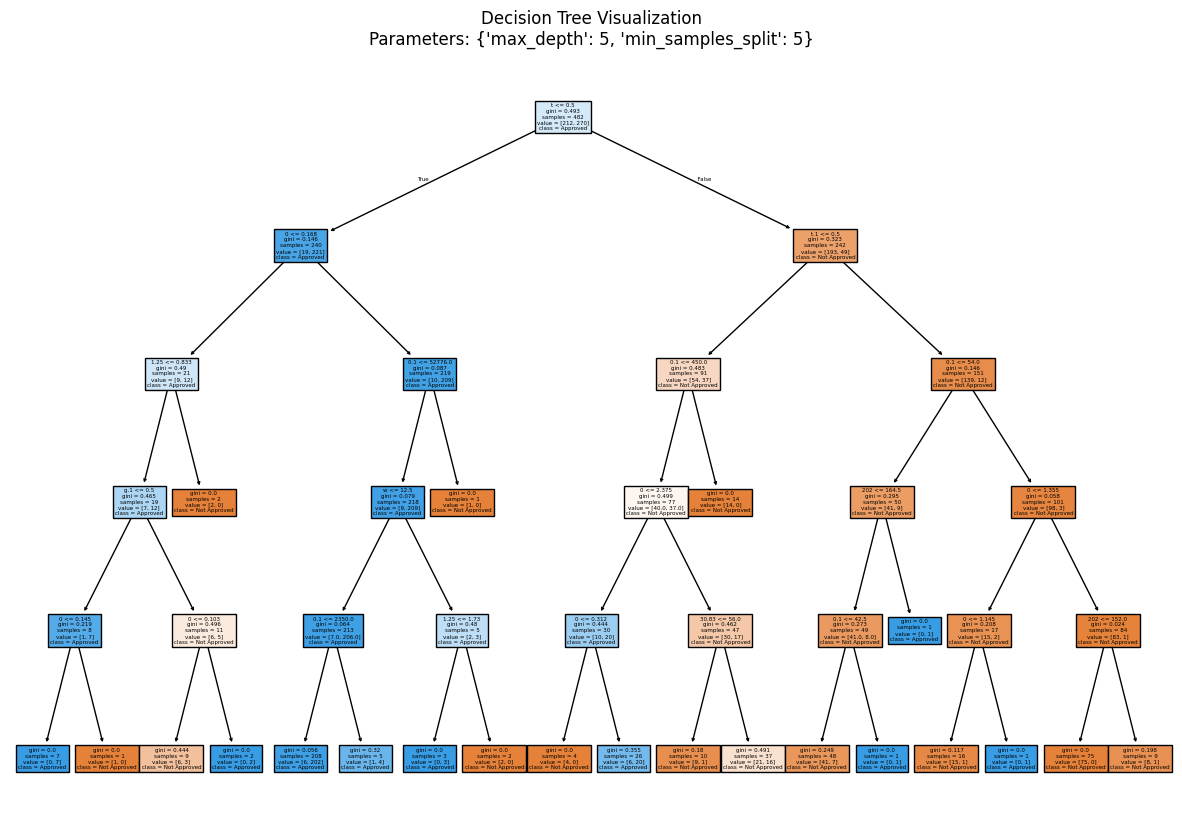

Test Accuracy: 0.84


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt

data = pd.read_csv('processed_cc_approvals.csv')
X = data.iloc[:, :-1]  # Features
y = data.iloc[:, -1]   # Labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


def train_and_visualize_decision_tree(X_train, y_train, X_test, y_test, **tree_params):
    clf = DecisionTreeClassifier(**tree_params, random_state=42)
    clf.fit(X_train, y_train)

    plt.figure(figsize=(15, 10))
    plot_tree(clf, feature_names=X_train.columns, class_names=["Not Approved", "Approved"], filled=True)
    plt.title(f"Decision Tree Visualization\nParameters: {tree_params}")
    plt.show()

    accuracy = clf.score(X_test, y_test)
    print(f"Test Accuracy: {accuracy:.2f}")

    return clf, accuracy

# Example Usage
parameters = {"max_depth": 3, "min_samples_split": 10}
clf, accuracy = train_and_visualize_decision_tree(X_train, y_train, X_test, y_test, **parameters)

parameters_2 = {"max_depth": 5, "min_samples_split": 10}
clf_2, accuracy_2 = train_and_visualize_decision_tree(X_train, y_train, X_test, y_test, **parameters_2)

parameters_2 = {"max_depth": 5, "min_samples_split": 5}
clf_2, accuracy_2 = train_and_visualize_decision_tree(X_train, y_train, X_test, y_test, **parameters_2)


The influencing properties of a Decision Tree include depth. A shallow tree-for example, interpretable, and less prone to overfit, but it underfits the data by missing the important patterns in it, hence giving lower accuracy. In contrast, the deeper the tree the more complicated the relationships it will pick up in the data, which often leads to high training accuracy but risks overfitting: the model memorizes noise or specific details and does not generalize well to unseen data. An unrestricted tree grows fully and perfectly classifies the training data but often performs poorly on test data due to overfitting. In general, tuning of hyperparameters controls the depth of the tree to balance bias and variance, generalizing well but still capturing useful patterns.

Sensitivity analysis is one such technique for coming to understand just how changes within the input parameters of a given model would then affect its output or performance. Applications in machine learning include evaluating hyperparameters like the learning rate, max depth, or subsample impacts on model accuracy or other evaluation metrics. Mostly, sensitivity analysis is developed based on changing at least one and sometimes more than one hyperparameter on a range and observing changes in performances. A common approach to performing sensitivity analysis is through grid search or random search, where a predefined set of hyperparameter values is tested, and the resulting model performance is evaluated. This allows practitioners to fine-tune their models, ensuring better generalization and optimization.

*citation:*
Bergstra, J., & Bengio, Y. (2012). Random search for hyper-parameter optimization. Journal of Machine Learning Research,

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


Percentage of grid points where predictions change: 0.00%


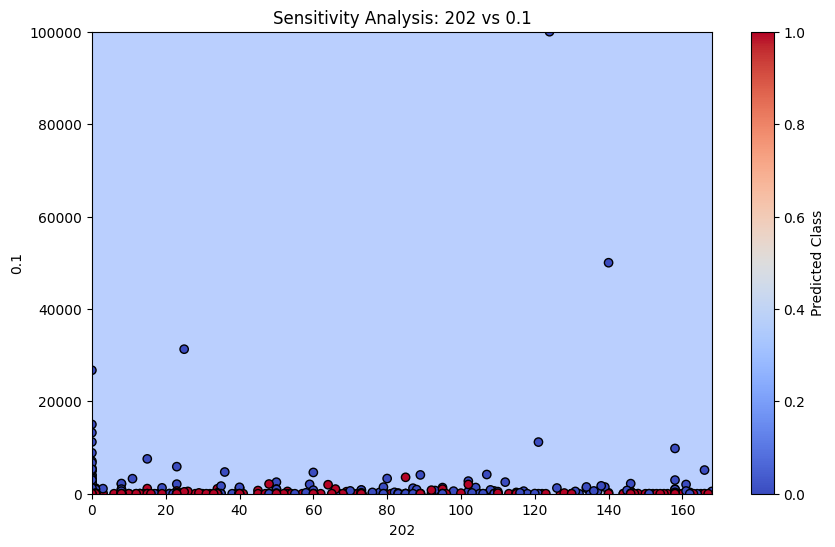

       Importance
t        0.816086
1        0.079745
0.1      0.057822
0        0.036874
1.25     0.009473
b        0.000000
30.83    0.000000
w        0.000000
v        0.000000
t.1      0.000000
f        0.000000
g.1      0.000000
202      0.000000


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
import pandas as pd

def sensitivity_analysis_with_results(X_train, y_train, clf, feature_1, feature_2):
    feature_1_range = np.linspace(X_train[feature_1].min(), X_train[feature_1].max(), 200)
    feature_2_range = np.linspace(X_train[feature_2].min(), X_train[feature_2].max(), 200)

    xx, yy = np.meshgrid(feature_1_range, feature_2_range)
    grid = np.c_[xx.ravel(), yy.ravel()]

    X_fixed = X_train.mean(axis=0).values.reshape(1, -1)
    X_fixed = np.repeat(X_fixed, grid.shape[0], axis=0)
    X_fixed[:, X_train.columns.get_loc(feature_1)] = grid[:, 0]
    X_fixed[:, X_train.columns.get_loc(feature_2)] = grid[:, 1]

    predictions = clf.predict(X_fixed)
    predictions = predictions.reshape(xx.shape)

    changes_in_prediction = np.zeros_like(predictions)
    changes_in_prediction[1:, :] += (predictions[1:, :] != predictions[:-1, :])
    changes_in_prediction[:, 1:] += (predictions[:, 1:] != predictions[:, :-1])
    change_percentage = np.sum(changes_in_prediction) / predictions.size * 100

    print(f"Percentage of grid points where predictions change: {change_percentage:.2f}%")

    plt.figure(figsize=(10, 6))
    plt.contourf(xx, yy, predictions, alpha=0.6, cmap='coolwarm')
    plt.scatter(X_train[feature_1], X_train[feature_2], c=y_train, cmap='coolwarm', edgecolor='k')
    plt.xlabel(feature_1)
    plt.ylabel(feature_2)
    plt.title(f"Sensitivity Analysis: {feature_1} vs {feature_2}")
    plt.colorbar(label="Predicted Class")
    plt.show()

# Example usage:
feature_1 = X.columns[11]  # Replace with the actual feature name
feature_2 = X.columns[12]  # Replace with the actual feature name

sensitivity_analysis_with_results(X_train, y_train, clf, feature_1, feature_2)


feature_importances = pd.DataFrame(clf.feature_importances_, index=X_train.columns, columns=["Importance"])
print(feature_importances.sort_values("Importance", ascending=False))


Based on the importance factor, it is clear that the last two features (202, 0.1) have insignificant role on the final decision boundary. As a result we expect huge impact based on the t parameter were the importance factor is equal to o.81

TASK 2

In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import make_scorer, accuracy_score, precision_score, f1_score

df = pd.read_csv("processed_cc_approvals.csv")
X = df.drop(columns=["+"])
y = df["+"]


bagging_model = RandomForestClassifier(n_estimators=100, random_state=42)
boosting_model = GradientBoostingClassifier(n_estimators=100, random_state=42)

folds_list = [5, 10, 15]

def evaluate_model_with_metrics(model, X, y, folds_list):
    results = {}
    scoring_metrics = {
        "Accuracy": make_scorer(accuracy_score),
        "Precision": make_scorer(precision_score, average="weighted"),
        "F1-Score": make_scorer(f1_score, average="weighted"),
    }

    for n_folds in folds_list:
        skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)
        metrics_results = {}

        for metric_name, scorer in scoring_metrics.items():
            scores = cross_val_score(model, X, y, cv=skf, scoring=scorer)
            metrics_results[metric_name] = {
                "Mean": np.mean(scores),
                "Std": np.std(scores),
            }

        results[n_folds] = metrics_results

    return results

# Evaluate bagging model
bagging_results = evaluate_model_with_metrics(bagging_model, X, y, folds_list)
print("Bagging Results (Random Forest):")
for folds, metrics in bagging_results.items():
    print(f"\n{folds} folds:")
    for metric, values in metrics.items():
        print(f"{metric} -> Mean: {values['Mean']:.4f}, Std: {values['Std']:.4f}")

# Evaluate boosting model
boosting_results = evaluate_model_with_metrics(boosting_model, X, y, folds_list)
print("\nBoosting Results (Gradient Boosting):")
for folds, metrics in boosting_results.items():
    print(f"\n{folds} folds:")
    for metric, values in metrics.items():
        print(f"{metric} -> Mean: {values['Mean']:.4f}, Std: {values['Std']:.4f}")


Bagging Results (Random Forest):

5 folds:
Accuracy -> Mean: 0.8666, Std: 0.0470
Precision -> Mean: 0.8692, Std: 0.0464
F1-Score -> Mean: 0.8664, Std: 0.0472

10 folds:
Accuracy -> Mean: 0.8666, Std: 0.0634
Precision -> Mean: 0.8701, Std: 0.0619
F1-Score -> Mean: 0.8666, Std: 0.0635

15 folds:
Accuracy -> Mean: 0.8681, Std: 0.0670
Precision -> Mean: 0.8725, Std: 0.0641
F1-Score -> Mean: 0.8675, Std: 0.0675

Boosting Results (Gradient Boosting):

5 folds:
Accuracy -> Mean: 0.8564, Std: 0.0476
Precision -> Mean: 0.8601, Std: 0.0459
F1-Score -> Mean: 0.8565, Std: 0.0473

10 folds:
Accuracy -> Mean: 0.8565, Std: 0.0926
Precision -> Mean: 0.8599, Std: 0.0914
F1-Score -> Mean: 0.8566, Std: 0.0925

15 folds:
Accuracy -> Mean: 0.8478, Std: 0.0828
Precision -> Mean: 0.8527, Std: 0.0792
F1-Score -> Mean: 0.8473, Std: 0.0835


Both algorithms—Random Forest with Bagging and Gradient Boosting—were checked by accuracy, precision, and F1-score for 5, 10, and 15 folds. In all three metrics, Random Forest consistently outperformed Gradient Boosting. Taking the results on 15 folds as an example, the accuracy of Random Forest was 0.8681, precision was 0.8725, and the F1-score was 0.8675, while the result of Gradient Boosting on accuracy was 0.8478, precision 0.8527, and F1-score 0.8473. Random Forest performed equally well or better, returning a standard deviation of 0.0670 in accuracy compared with 0.0828 from Gradient Boosting.
Gradient Boosting was competitive but a bit worse, with higher variability across folds, especially for larger fold sizes. For example, the accuracy for 5 folds decreases from 0.8564 to 0.8478 for 15 folds. It is sensitive to data splits because of its sequential learning approach; it amplifies noise or overfitting to smaller subsets. Overall, Random Forest is the best model on this dataset considering stability and performance across different metrics.



TASK 3

Confusion Matrices for Each Algorithm across 10-fold:

For 10-fold:

Decision Tree Confusion Matrix:


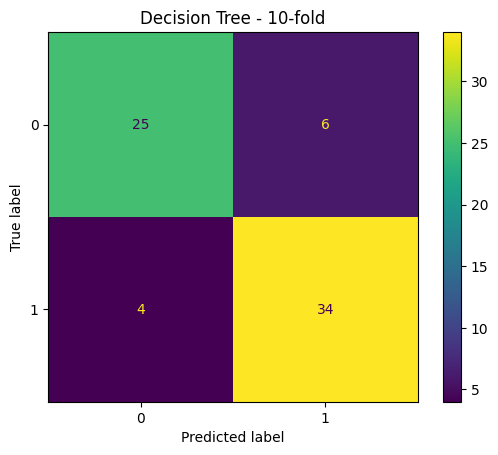


Random Forest Confusion Matrix:


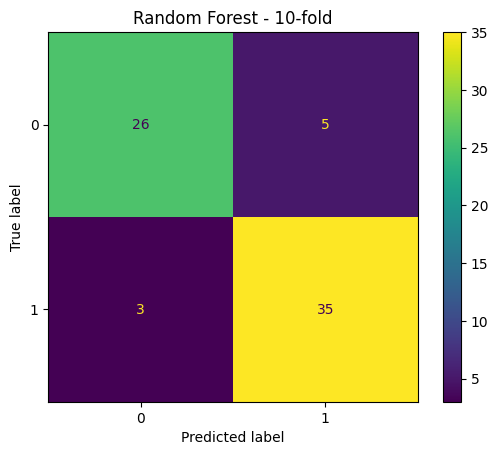


Gradient Boosting Confusion Matrix:


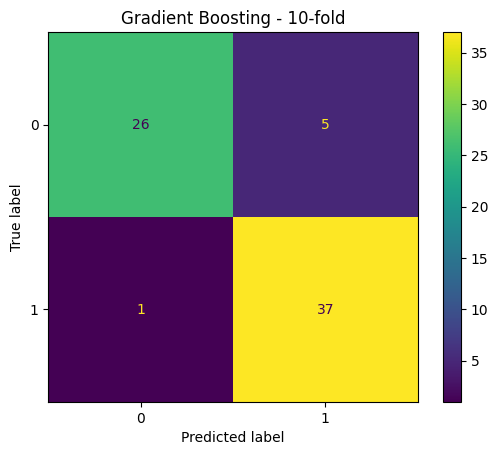


Paired t-tests for Algorithm Performance at 10-fold:

Comparison: Decision Tree vs Random Forest - 10-fold
t-statistic: -6.8693, p-value: 0.0001
=> Significant difference between models (p < 0.05)

Comparison: Decision Tree vs Gradient Boosting - 10-fold
t-statistic: -3.0538, p-value: 0.0137
=> Significant difference between models (p < 0.05)

Comparison: Random Forest vs Gradient Boosting - 10-fold
t-statistic: 0.7802, p-value: 0.4553
=> No significant difference between models (p >= 0.05)


In [ ]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from scipy.stats import ttest_rel
import matplotlib.pyplot as plt


df = pd.read_csv("processed_cc_approvals.csv")
X = df.drop(columns=["+"])
y = df["+"]


dt_model = DecisionTreeClassifier(random_state=42)
bagging_model = RandomForestClassifier(n_estimators=100, random_state=42)
boosting_model = GradientBoostingClassifier(n_estimators=100, random_state=42)
k_folds = [10]

models = {"Decision Tree": dt_model, "Random Forest": bagging_model, "Gradient Boosting": boosting_model}


fold_accuracies = {model_name: {fold: [] for fold in k_folds} for model_name in models.keys()}
confusion_matrices = {fold: {} for fold in k_folds}


for fold_size in k_folds:
    skf = StratifiedKFold(n_splits=fold_size, shuffle=True, random_state=42)

    for fold_idx, (train_idx, test_idx) in enumerate(skf.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        for model_name, model in models.items():
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)


            acc = accuracy_score(y_test, y_pred)
            fold_accuracies[model_name][fold_size].append(acc)


            if fold_idx == 0:
                confusion_matrices[fold_size][model_name] = confusion_matrix(y_test, y_pred)


print("Confusion Matrices for Each Algorithm across 10-fold:")

for fold_size in k_folds:
    print(f"\nFor {fold_size}-fold:")
    for model_name, cm in confusion_matrices[fold_size].items():
        print(f"\n{model_name} Confusion Matrix:")
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot()
        plt.title(f"{model_name} - {fold_size}-fold")
        plt.show()


print("\nPaired t-tests for Algorithm Performance at 10-fold:")

# Compare the models
for fold_size in k_folds:
    acc_dt = fold_accuracies["Decision Tree"][fold_size]
    acc_rf = fold_accuracies["Random Forest"][fold_size]
    acc_gb = fold_accuracies["Gradient Boosting"][fold_size]

    print(f"\nComparison: Decision Tree vs Random Forest - {fold_size}-fold")
    t_stat, p_value = ttest_rel(acc_dt, acc_rf)
    print(f"t-statistic: {t_stat:.4f}, p-value: {p_value:.4f}")
    if p_value < 0.05:
        print("=> Significant difference between models (p < 0.05)")
    else:
        print("=> No significant difference between models (p >= 0.05)")

    print(f"\nComparison: Decision Tree vs Gradient Boosting - {fold_size}-fold")
    t_stat, p_value = ttest_rel(acc_dt, acc_gb)
    print(f"t-statistic: {t_stat:.4f}, p-value: {p_value:.4f}")
    if p_value < 0.05:
        print("=> Significant difference between models (p < 0.05)")
    else:
        print("=> No significant difference between models (p >= 0.05)")

    print(f"\nComparison: Random Forest vs Gradient Boosting - {fold_size}-fold")
    t_stat, p_value = ttest_rel(acc_rf, acc_gb)
    print(f"t-statistic: {t_stat:.4f}, p-value: {p_value:.4f}")
    if p_value < 0.05:
        print("=> Significant difference between models (p < 0.05)")
    else:
        print("=> No significant difference between models (p >= 0.05)")



A normal Decision Tree usually has high variance and low bias, meaning that it has over-fitted to the training data. Thus, it performed extremely well on the training sets but extremely poor in any unseen data. From the t-tests, it can be seen that it performed significantly worse than Random Forest and Gradient Boosting because of its sensitivity to noise and high variance.

Since Random Forest reduces the variance by averaging several trees, it has lower variance but higher bias compared with Decision Trees. It significantly outperforms the Decision Tree while showing similar performances to Gradient Boosting; it is a very reliable model since it has a good bias-variance trade-off.

Gradient Boosting: Gradient Boosting builds trees sequentially to reduce variance. It has lower bias and moderate variance. It outperforms Decision Trees by a wide margin and performs similarly to Random Forest. It is very efficient in reducing bias but demands more tuning and computational resources.

In terms of bias-variance trade-off, the highest variance comes from Decision Trees, while Random Forest makes a very good balance between bias and variance. Gradient Boosting strikes the best balance, reducing bias at not too high variance. Statistically, Random Forest and Gradient Boosting are doing equally good; still, Gradient Boosting does a better job than Random Forest in most applications. Since most use cases will go for simplicity, usually, Random Forest is preferred, whereas Gradient Boosting does wonders when bias reduction is key.

EXTRA TASK

Best hyperparameters found: learning_rate    0.010000
max_depth        7.000000
subsample        1.000000
accuracy         0.862319
Name: 8, dtype: float64
Accuracy: 0.8623
Precision: 0.8590
F1 Score: 0.8758


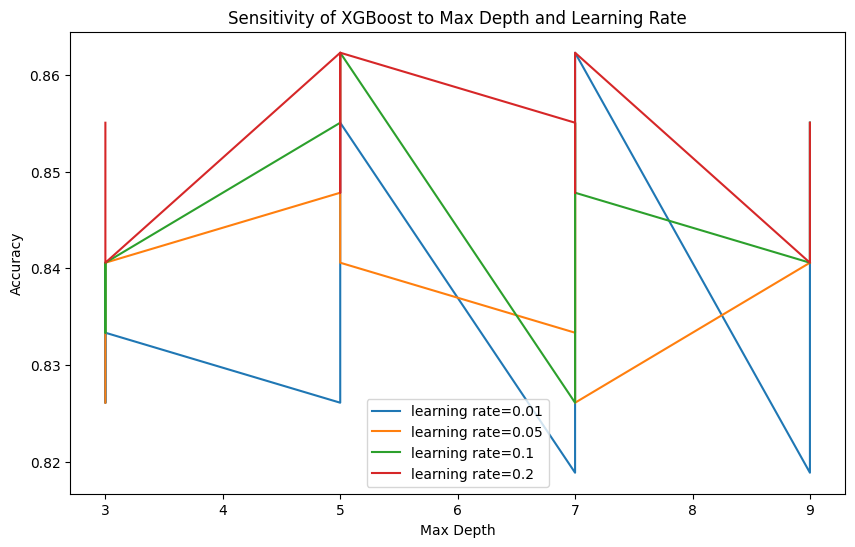

In [ ]:
import xgboost as xgb
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, f1_score
import matplotlib.pyplot as plt

data = pd.read_csv('processed_cc_approvals.csv')
X = data.iloc[:, :-1]
y = data.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


learning_rates = [0.01, 0.05, 0.1, 0.2]
max_depths = [3, 5, 7, 9]
subsamples = [0.6, 0.8, 1.0]

results = {'learning_rate': [], 'max_depth': [], 'subsample': [], 'accuracy': []}


for lr in learning_rates:
    for depth in max_depths:
        for subsample in subsamples:
            model = xgb.XGBClassifier(learning_rate=lr,
                                      max_depth=int(depth),
                                      subsample=subsample,
                                      tree_method='auto')
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            accuracy = accuracy_score(y_test, y_pred)


            results['learning_rate'].append(lr)
            results['max_depth'].append(int(depth))
            results['subsample'].append(subsample)
            results['accuracy'].append(accuracy)


sensitivity_df = pd.DataFrame(results)

best_params = sensitivity_df.loc[sensitivity_df['accuracy'].idxmax()]
print(f"Best hyperparameters found: {best_params}")

best_xgb_model = xgb.XGBClassifier(learning_rate=best_params['learning_rate'],
                                   max_depth=int(best_params['max_depth']),
                                   subsample=best_params['subsample'],
                                   tree_method='auto')
best_xgb_model.fit(X_train, y_train)


y_pred = best_xgb_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1 Score: {f1:.4f}")


plt.figure(figsize=(10, 6))
for lr in sensitivity_df['learning_rate'].unique():
    subset = sensitivity_df[sensitivity_df['learning_rate'] == lr]
    plt.plot(subset['max_depth'], subset['accuracy'], label=f'learning rate={lr}')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.title('Sensitivity of XGBoost to Max Depth and Learning Rate')
plt.legend()
plt.show()
